In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

import seaborn as sns

### Data Exploration & Feature Engineering

In [2]:
subs = pd.read_csv('user_subscriptions.csv', header = 0)
subs['Join Date']=pd.to_datetime(subs['Join Date'],format='%b-%y')
subs['End Date']=pd.to_datetime(subs['End Date'],format='%b-%y')

for col in ['Club', 'Gender', 'Subscription Type']:
    subs[col] = subs[col].astype('category')

subs["Affluence"] = subs["Affluence"].astype("category").cat.set_categories(
    ["A", "B", "C1", "C2", "DE"], ordered=True #changed to False, as some graphs were not working well with ordered categories
)

#assume memberships expire on the last day of month
subs['End Date'] = subs['End Date'] + pd.tseries.offsets.MonthEnd()

### Exploratory Data Analysis. Customer Segmentation###

**(!) Gender Data** 
The company should carefully weigh the legal and ethical considerations when dealing with gender data. 
We reviewed the gender data as a part of the exploratory data analysis, though would not recommend using it for segmentation or pricing policy purposes

**Hypothesis**: 'No frills' sport clubs are likely to attract more male customers than female. 
<br>**Conclusion**: Hypothesis did not hold based on the data analysis. The two genders were almost equally prepresented across all clubs.
<br>Neither was the gender a differentiator for subscription types (Standard vs Flexible). 
<br>Men and Women were also equally represented in all Affluence Groups, as defined by the company and across all age groups.

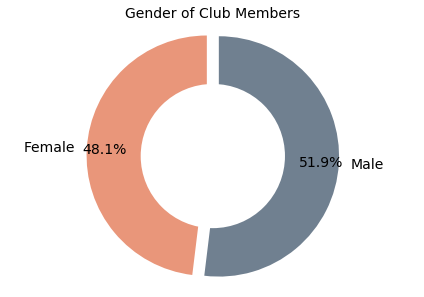

In [54]:
gend = subs.groupby('Gender')['Gender'].count()
colors = ['darksalmon','slategrey']
fig1, ax1 = plt.subplots()
explode = (0.05,0.05)
patches, texts, autotexts = ax1.pie(gend, colors = colors, labels=gend.index, autopct='%1.1f%%', 
                                    textprops={'fontsize': 14}, startangle=90,
                                    pctdistance=0.85, explode = explode)

centre_circle = plt.Circle((0,0),0.60,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
ax1.axis('equal')  
plt.tight_layout()
plt.title('Gender of Club Members', fontsize = 14)
plt.show()

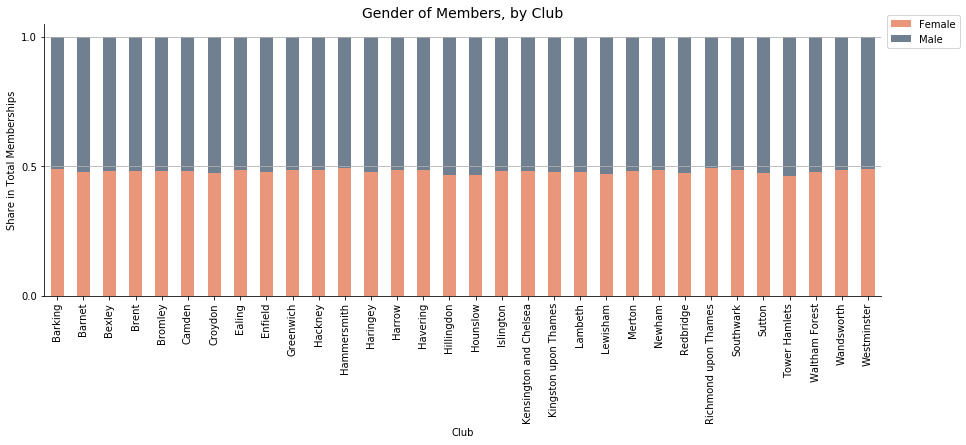

In [55]:
gender_club = subs.groupby(['Club', 'Gender'])['CustomerID'].count().rename("count")
gender_club_pct =gender_club / gender_club.groupby(level=0).sum()
gender_club_pct.unstack().plot(kind = 'bar', stacked = True,color = colors, figsize=(15, 5))
plt.legend()
plt.yticks((0, 0.5, 1))
plt.grid(which ='major', axis = 'y')
plt.ylabel("Share in Total Memberships")
plt.title('Gender of Members, by Club', fontsize = 14)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

Text(0.5, 1.0, 'Gender of Members, by Age Group')

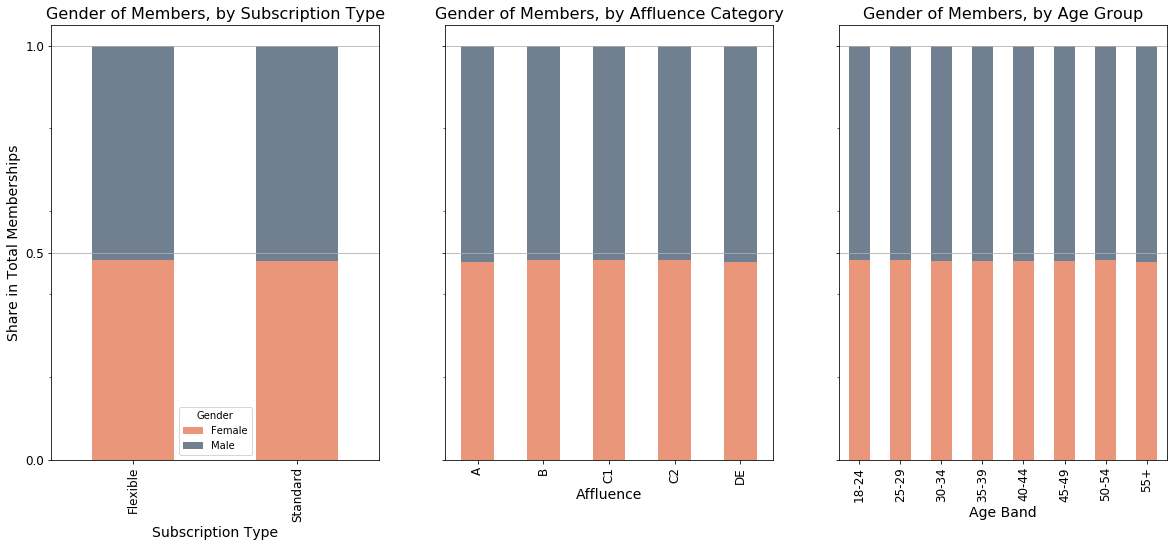

In [127]:
# To run this run Gender Data below first 
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,8), sharey=True)

gender_subs = subs.groupby(['Subscription Type', 'Gender'])['CustomerID'].count().rename("count")
gender_subs_pct =gender_subs / gender_subs.groupby(level=0).sum()
gender_subs_pct.unstack().plot(ax = axes[0], fontsize = 12, kind = 'bar', 
                               stacked = True, color = colors, label = True).grid(which ='major', axis = 'y')
axes[0].set_yticks((0,0.5,1))
axes[0].set_xlabel("Subscription Type", fontsize = 14)
axes[0].set_ylabel("Share in Total Memberships", fontsize = 14)
axes[0].set_title('Gender of Members, by Subscription Type', fontsize = 16)

gender_affl = subs.groupby(['Affluence', 'Gender'])['CustomerID'].count().rename("count")
gender_affl_pct =gender_affl / gender_affl.groupby(level=0).sum()
gender_affl_pct.unstack().plot(ax = axes[1], fontsize = 12, kind = 'bar', stacked = True, color = colors, label = True, legend = False).grid(which ='major', axis = 'y')
axes[1].set_yticks((0, 0.5, 1))
axes[1].set_xlabel("Affluence", fontsize = 14)
axes[1].set_ylabel("Share in Total Memberships", fontsize = 14)
axes[1].set_title('Gender of Members, by Affluence Category', fontsize = 16)

gender_age = subs.groupby(['age_band', 'Gender'])['CustomerID'].count().rename("count")
gender_age_pct =gender_age / gender_age.groupby(level=0).sum()
gender_age_pct.unstack().plot(ax = axes[2], fontsize = 12,kind = 'bar', stacked = True, color = colors, label = True, legend = False).grid(which ='major', axis = 'y')
axes[2].set_yticks((0, 0.5, 1))
axes[2].set_xlabel("Age Band", fontsize = 14)
axes[2].set_ylabel("Share in Total Memberships", fontsize = 14)
axes[2].set_title('Gender of Members, by Age Group', fontsize = 16)




**Age Data**

**Hypothesis**: Budget gyms are most attractive for younger population.
<br>**Conclusion**: The hypothesis is confirmed: almost half of the company club memberships are started by people aged between 18 and 30, and approximately 85% of the members subscribe when they are younger than 40.

**Hypothesis**: Affluence level is largely driven by members' age.
<br>**Conclusion**: This hypothesis somewhat exaggerated the impact of age on the Affluence composition. We do see a reduction in the high Affluence members (category A and B), though it is a combination of the facts that (1) Category B is prevalent in the company's customer base, and (2) the fact that members of this particular category join the company's gyms in reducing numbers as they get older. 
<br> This offers an insight which might be worth investigating further: Assuming that people continue to exercise as they progress though their 20s, 30s and 40s, high Affluence customers (Cat B) seem to be moving to gyms of higher tiers. As the result OC&Gym are attacting decreasing numbers of members from this important category. 

**Hypothesis**: As the value proposition has not changed over the years, the age group composition of gym members remained stable.
<br>**Conclusion**: This hypothesis is confirmed by the data, as the age group composition over the years remained incredibly consistent.

In [57]:
# new variables - age at join date & age_group

def compute_age(row):
    return row["Join Date"].year - row["BirthYear"]

subs["age"] = subs.apply(compute_age, axis=1)

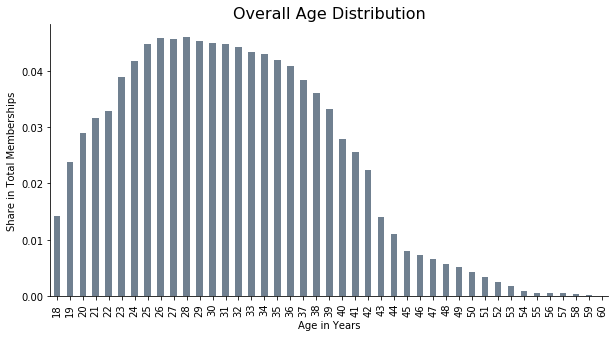

In [58]:
subs["age"].value_counts(normalize=True, sort=False).plot.bar(figsize=(10, 5), color = 'slategrey')
plt.title('Overall Age Distribution', fontsize = 16)
plt.xlabel("Age in Years")
plt.ylabel("Share in Total Memberships")
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

Breaking the ages down in 5-year bands creates similar-sized groups for the largest member base (18-35).

In [60]:
#creating age bands

subs["age_band"] = pd.cut(
    subs["age"], 
    bins=(17, 25, 30, 35, 40, 45, 50, 55, 99), 
    labels=["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55+"]
)
subs["age_band"] = subs["age_band"].astype("category").cat.set_categories(
    ["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55+"], ordered=True
)

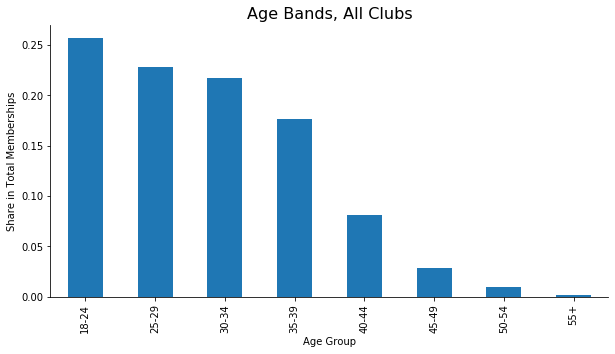

In [61]:
subs["age_band"].value_counts(normalize=True, sort=False).plot.bar(figsize=(10,5))
plt.title('Age Bands, All Clubs', fontsize = 16)
plt.xlabel("Age Group")
plt.ylabel("Share in Total Memberships")
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

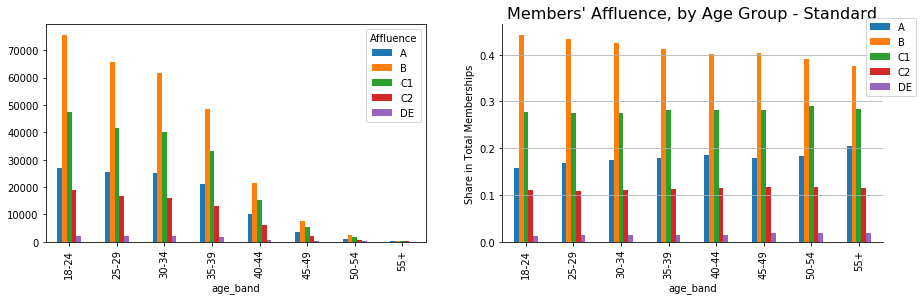

In [204]:
#We do see a reduction in the high Affluence members (category A and B), though it is a combination of 
#the facts that (1) Category B is prevalent in the company's customer base, and 
#(2) the fact that members of this particular category join the company's gyms in reducing numbers as they get older.
#This offers an insight which might be worth investigating further: 
#Assuming that people continue to exercise as they progress though their 20s, 30s and 40s, 
#high Affluence customers (Cat B) seem to be moving to gyms of higher tiers. 
#As the result OC&Gym are attacting decreasing numbers of members from this important category. 
fig, ax = plt.subplots(ncols=2, figsize=(15,4))

subs[subs['Subscription Type']=='Standard'].groupby(['age_band', 'Affluence'])['CustomerID'].count().unstack().plot(kind = 'bar',ax = ax[0])


age_affl = subs[subs['Subscription Type']=='Standard'].groupby(['age_band','Affluence'])['CustomerID'].count().rename("count")
age_affl_pct =age_affl / age_affl.groupby(level=0).sum()
age_affl_pct.unstack().plot(kind = 'bar',ax = ax[1])
plt.legend()
plt.grid(which ='major', axis = 'y')
plt.ylabel("Share in Total Memberships")
plt.title("Members' Affluence, by Age Group - Standard", fontsize = 16)
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

Text(0, 0.5, 'Share in New Memberships')

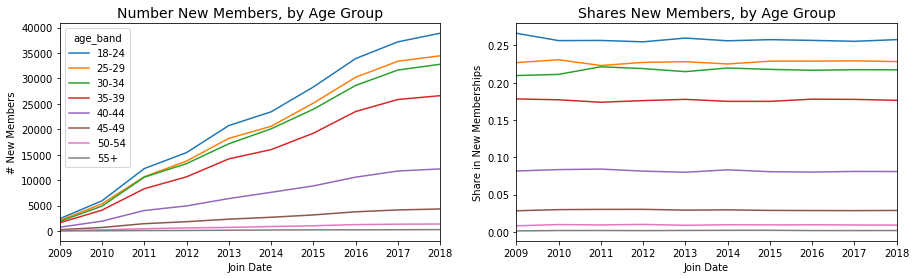

In [120]:
#with the increasing number of clubs the number of new members have been growing, though the composition of 
#age groups remained incredibly consistent over the years

fig, ax = plt.subplots(ncols=2, figsize=(15,4))
subs.groupby([subs['Join Date'].dt.strftime('%Y'), subs['age_band']])['age_band'].\
count().unstack().plot(label = True, ax = ax[0])
ax[0].set_title('Number New Members, by Age Group', fontsize = 14)
ax[0].set_ylabel("# New Members")



age_yr = subs.groupby([subs['Join Date'].dt.strftime('%Y'),subs['age_band']])['CustomerID'].count().rename("count")
age_yr_pct =age_yr / age_yr.groupby(level=0).sum()
age_yr_pct.unstack().plot(legend = False, ax = ax[1])
ax[1].set_title('Shares New Members, by Age Group', fontsize = 14)
ax[1].set_ylabel("Share in New Memberships")



Age distribution across the clubs is fairly consistent as well.

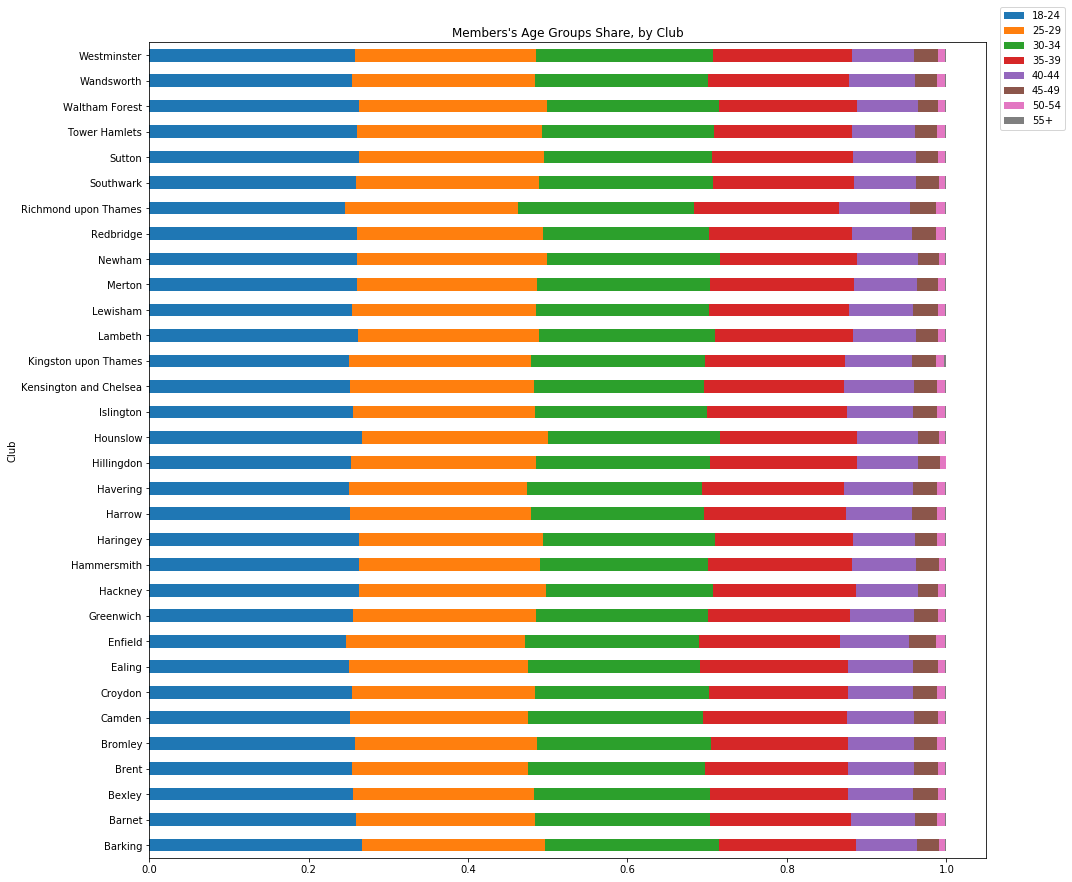

In [135]:
age_groups_club = subs.groupby(['Club', 'age_band'])['CustomerID'].count().rename("count")
age_groups_club_pct =age_groups_club / age_groups_club.groupby(level=0).sum()
age_groups_club_pct.unstack().plot(kind = 'barh', stacked = True, figsize=(15, 15))
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.title("Members's Age Groups Share, by Club")
plt.show()

**Affluence Data**

**Hypothesis**: As the value proposition has not changed over the years, the Affluence Category composition of gym members remained stable.
<br>**Conclusion**: Similarly to the age composition hypothesis above, this hypothesis is confirmed by the data.
<br>Having said that, on the individual club level the Affluence difference is more pronounced, as can be expected depending on the average affluence of neighborhoods. 

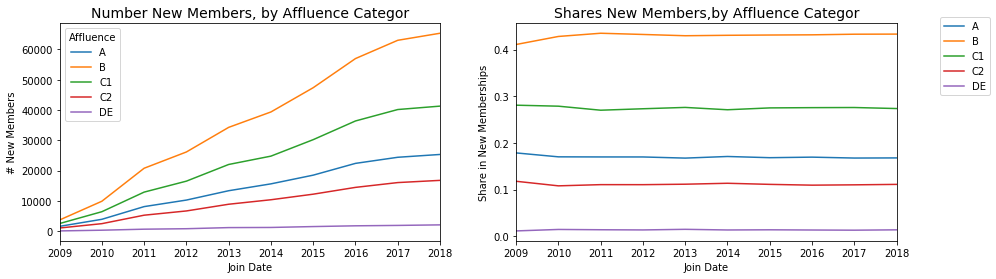

In [119]:
#distribution of Affluence categories have been consistent, similarly to (and probably in line with) the age group distribution

fig, ax = plt.subplots(ncols=2, figsize=(15,4))
subs.groupby([subs['Join Date'].dt.strftime('%Y'), subs['Affluence']])['Affluence'].\
count().unstack().plot(label = True, ax = ax[0])
ax[0].set_title('Number New Members, by Affluence Categor', fontsize = 14)
ax[0].set_ylabel("# New Members")



affl_yr = subs.groupby([subs['Join Date'].dt.strftime('%Y'),subs['Affluence']])['Affluence'].count().rename("count")
affl_yr_pct =affl_yr / affl_yr.groupby(level=0).sum()
affl_yr_pct.unstack().plot(label = True, ax = ax[1], legend = False)
ax[1].set_title('Shares New Members,by Affluence Categor', fontsize = 14)
ax[1].set_ylabel("Share in New Memberships")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

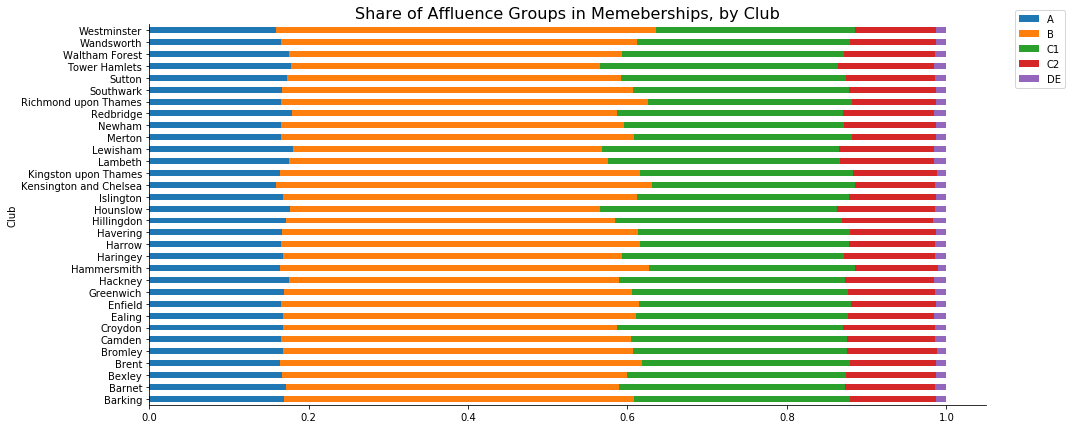

In [136]:
#on the individual club level 
#the Affluence difference is more pronounced, as can be expected depending on the average affluence of neighborhoods.
affluence_club = subs.groupby(['Club', 'Affluence'])['CustomerID'].count().rename("count")
affluence_club_pct =affluence_club / affluence_club.groupby(level=0).sum()
affluence_club_pct.unstack().plot(kind = 'barh', stacked = True, figsize=(15, 7))

plt.title('Share of Affluence Groups in Memeberships, by Club', fontsize = 16)
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

**Duration of Memberships (Tenure)**

**Hypothesis**: Flexible subscriptions bring in more revenue per member, thanks to the higher monthly rates.
<br>**Conclusion**: Reject this hypothesis, as members with Flexible subscriptions stay with the clubs for significantly shorter periods, compared to Standard plan customers. As the result, their revenue per customer is lower than Standard. 

**Hypothesis**: Considering the same service level at all clubs, average tenure length is consistent across clubs.
<br>**Conclusion**: This hypothesis is not supported by data, as we can see relatively sighnificant variations in the avg tenure levels by club.
<br>Area for further investigation: it appears that the clubs with higher tenure levels have been reducing membership level from their top capacity. Possible that the customer satisfaction (and longer tenure) is a result of less crowded gyms.

In [87]:
# new variable - tenure (in months), how long a person maintained membership in a club

def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month +1 # the memberships started and ended in the same month conted as 1 month tenure

def compute_tenure(row):
    end = datetime(2019, 1, 1) if pd.isnull(row["End Date"]) else row["End Date"]
    start = row["Join Date"]
    return diff_month(end, start)

subs["tenure"] = subs.apply(compute_tenure, axis=1)

**Review Tenure**

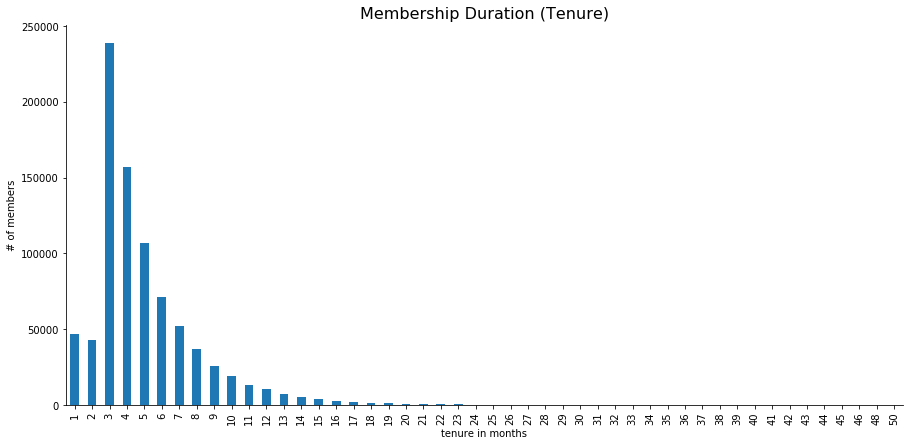

In [88]:
#Tenure distribution is skewed to the left with a long thin tail. 
subs["tenure"].value_counts(normalize=False, sort=False).plot.bar(figsize=(15, 7))
plt.title('Membership Duration (Tenure)', fontsize = 16)
plt.ylabel("# of members")
plt.xlabel("tenure in months")
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

Look at membership mean tenure by Club

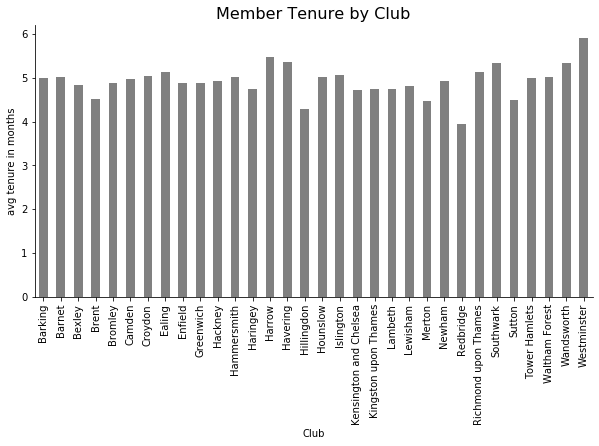

In [89]:
subs.groupby(['Club'])['tenure'].mean().plot.bar(color = 'grey',figsize=(10,5))
plt.title('Member Tenure by Club', fontsize = 16)
plt.ylabel("avg tenure in months")
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

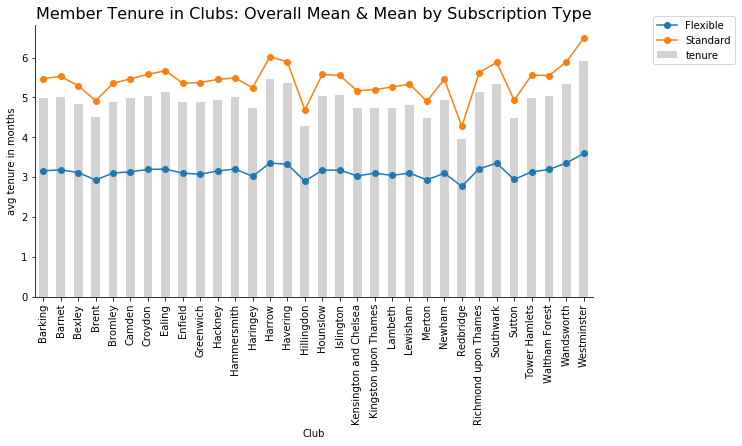

In [287]:
subs.groupby(['Club', 'Subscription Type'])['tenure'].mean().unstack().plot.line(marker="o",figsize=(10,5))
plt.legend(loc='lower right')
subs.groupby(['Club'])['tenure'].mean().plot.bar(color = 'lightgrey')
plt.title('Member Tenure in Clubs: Overall Mean & Mean by Subscription Type', fontsize = 16)
plt.ylabel("avg tenure in months")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

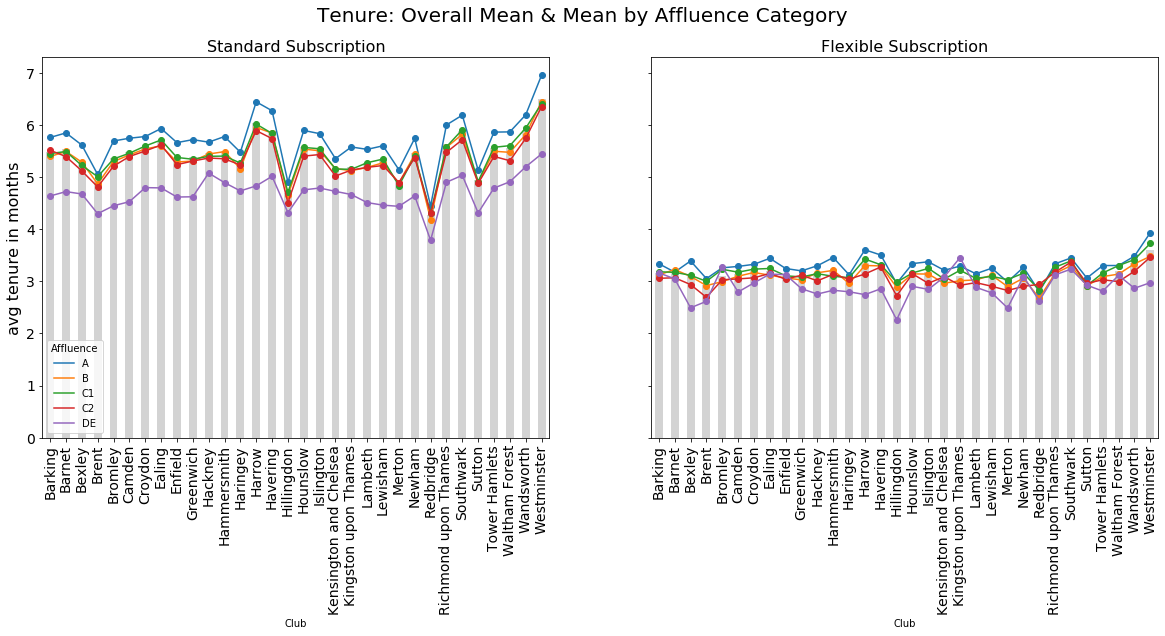

In [126]:
fig, ax = plt.subplots(ncols=2, figsize=(20,7), sharey=True)
fig.suptitle('Tenure: Overall Mean & Mean by Affluence Category', fontsize = 20)

subs[subs['Subscription Type']=='Standard'].groupby(['Club', 'Affluence'])['tenure'].mean().\
unstack().plot.line(marker="o", ax = ax[0], fontsize = 14)
subs[subs['Subscription Type']=='Standard'].groupby(['Club'])['tenure'].mean().plot.bar(color = 'lightgrey', ax = ax[0])
ax[0].set_title('Standard Subscription', fontsize = 16)
ax[0].set_ylabel("avg tenure in months", fontsize = 16)



subs[subs['Subscription Type']=='Flexible'].groupby(['Club', 'Affluence'])['tenure'].mean().\
unstack().plot.line(marker="o", ax = ax[1], fontsize = 14, legend = False)
subs[subs['Subscription Type']=='Flexible'].groupby(['Club'])['tenure'].mean().plot.bar(color = 'lightgrey', ax = ax[1])
ax[1].set_title('Flexible Subscription', fontsize = 16)
ax[1].set_ylabel("avg tenure in months")
plt.show()

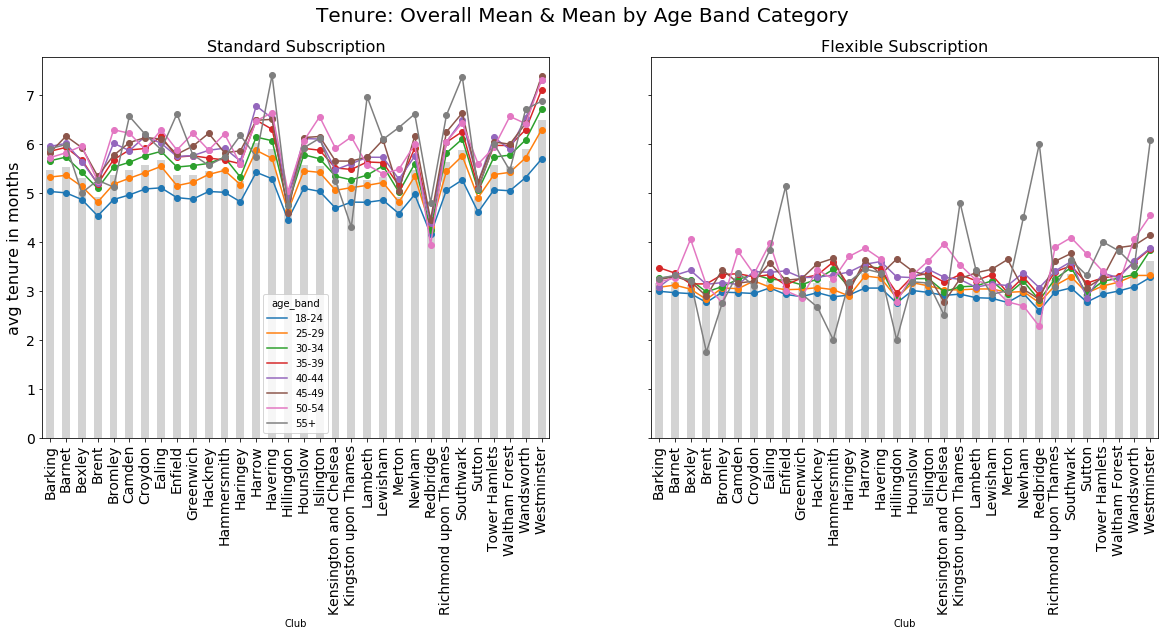

In [123]:
fig, ax = plt.subplots(ncols=2, figsize=(20,7), sharey=True)
fig.suptitle('Tenure: Overall Mean & Mean by Age Band Category', fontsize = 20)

subs[subs['Subscription Type']=='Standard'].groupby(['Club', 'age_band'])['tenure'].mean().\
unstack().plot.line(marker="o", ax = ax[0], fontsize = 14)
subs[subs['Subscription Type']=='Standard'].groupby(['Club'])['tenure'].mean().plot.bar(color = 'lightgrey', ax = ax[0])
ax[0].set_title('Standard Subscription', fontsize = 16)
ax[0].set_ylabel("avg tenure in months", fontsize = 16)



subs[subs['Subscription Type']=='Flexible'].groupby(['Club', 'age_band'])['tenure'].mean().\
unstack().plot.line(marker="o", ax = ax[1], fontsize = 14, legend = False)
subs[subs['Subscription Type']=='Flexible'].groupby(['Club'])['tenure'].mean().plot.bar(color = 'lightgrey', ax = ax[1])
ax[1].set_title('Flexible Subscription', fontsize = 16)
ax[1].set_ylabel("avg tenure in months")
plt.show()

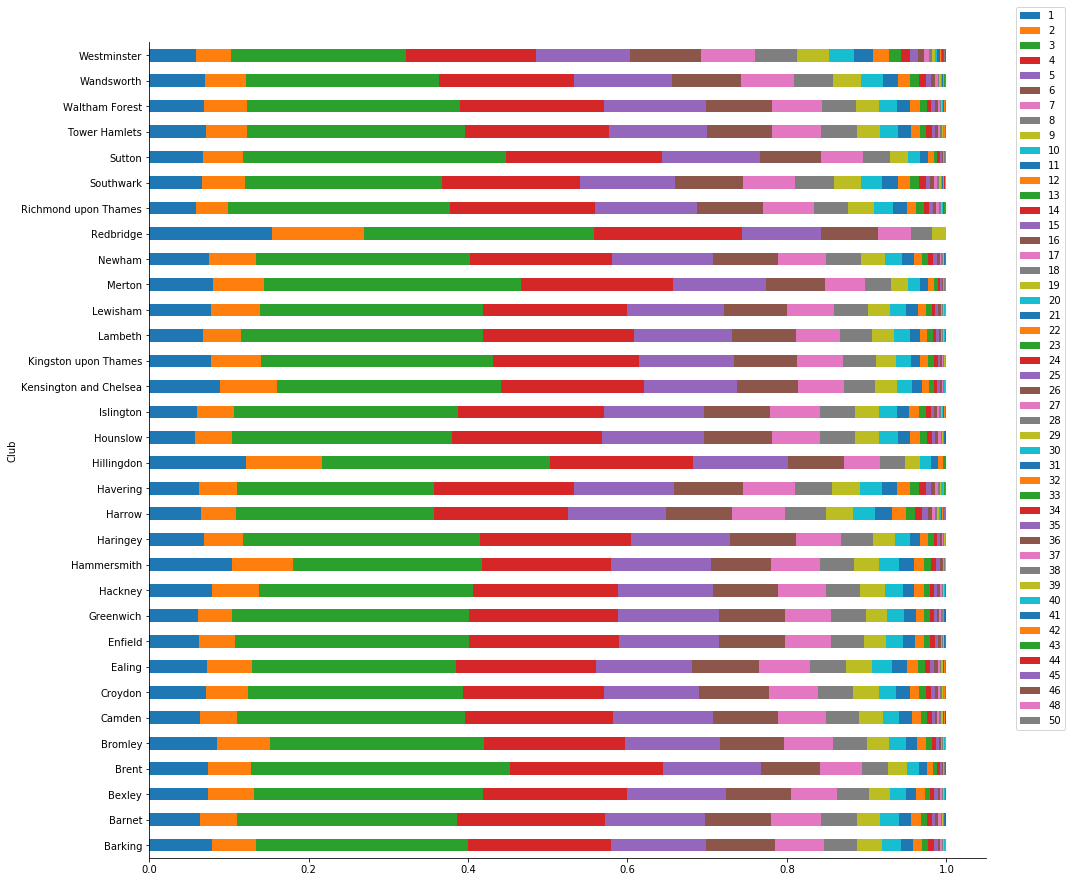

In [156]:
tenure_club = subs.groupby(['Club', 'tenure'])['CustomerID'].count().rename("count")
tenure_club_pct =tenure_club / tenure_club.groupby(level=0).sum()
tenure_club_pct.unstack().plot(kind = 'barh', stacked = True, figsize=(15, 15))
plt.legend()
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

**Clubs & Expansion History**

**Hypothesis**: The company has been consistently growing its presence in London boroughs across the years.
<br>**Conclusion**: This hypothesis is largely confimed by data: OC&G increased number of gyms from 3 in 2009 to 33 by the end of 2018, introducing 3 new locations per year on average. The customer base growth is not uniform though, as  there is a pronounced seasonality to new subscriptions (cold season and NY), amplified by the fact that a large number of new clubs are introduced at the end of the year (which is accompanied by the main markekting effort).

**Hypothesis**: As all clubs have similar capacity (based on the discussion with stakeholders), we expect that each club experienced the same ramp up stage, after which each club membership stabilized at the the same level.
<br>**Conclusion**: Although all the clubs do have similar capacity, their ramp up profile as well as the membership levels after the initial stage differ quite substantially. Might be worth further, more granular investigation of the reasons for such differences.

**(!) Hypothesis to investigate**: There is a significant increase in membership cancelations at the end of each year (for both Standard and Flexible plans). This could be an indication that the members are planning to start the new year with a membership is a different club. If that is the case, company should consider measures to keep these members (e.g. offer a December discount if the membership is renewed for the next year, free day passes (can be used as Xmas presents to friends), etc.) The way to quantify the impact would be by comparison of the benefits offeres to members with the cost of new aquisitions.
The customers who remain with the club in November-December are less likely to leave in the following months.

In [60]:
# look at the company expansion and addition of new clubs
club_open=subs.groupby('Club')['Join Date'].min().sort_values()
club_open

Club
Hounslow                 2009-05-01
Greenwich                2009-07-01
Richmond upon Thames     2009-10-01
Enfield                  2010-03-01
Lambeth                  2010-08-01
Harrow                   2011-01-01
Barnet                   2011-02-01
Islington                2011-04-01
Havering                 2011-06-01
Westminster              2011-08-01
Tower Hamlets            2011-12-01
Camden                   2012-06-01
Haringey                 2012-11-01
Sutton                   2013-01-01
Waltham Forest           2013-04-01
Croydon                  2013-06-01
Wandsworth               2013-10-01
Southwark                2014-03-01
Newham                   2014-09-01
Brent                    2014-10-01
Ealing                   2014-12-01
Lewisham                 2015-01-01
Bexley                   2015-07-01
Hackney                  2015-12-01
Barking                  2016-03-01
Kingston upon Thames     2016-05-01
Merton                   2016-07-01
Bromley                

In [61]:
# new variable - club_open, showing the date of first membership
subs['club_open']=subs['Join Date'].groupby(subs['Club']).transform('min')
subs['club_open_yr'] = pd.DatetimeIndex(subs['club_open']).year

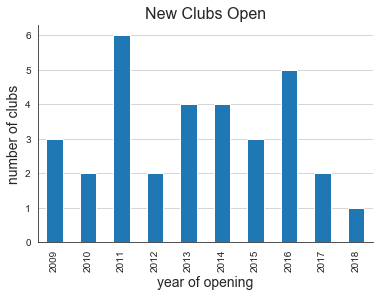

In [62]:
subs.groupby(subs['club_open'].dt.strftime('%Y'))['Club'].nunique().plot(kind = 'bar')
plt.xlabel('year of opening', fontsize = 14)
plt.ylabel('number of clubs', fontsize = 14)
plt.title('New Clubs Open', fontsize = 16)
plt.grid(b=None)
plt.grid(which = 'major', axis = 'x')
plt.gca().spines['right'].set_color('none')
plt.gca().spines['top'].set_color('none')
plt.show()

The company opened 3 new clubs every year on average 

In [63]:
subs.groupby(subs['club_open'].dt.strftime('%Y'))['Club'].nunique().mean()

3.2

**New Member Aquisition**

New member aquisition numbers are driven by new club openings and the seasonality of the business.

In [ ]:
curr_members = subs.set_index('Join Date')
curr_members.sort_index(inplace= True)
curr_members['End Date'].fillna(value=pd.to_datetime('12/31/2018'), inplace=True)
curr_members['curr_members']=curr_members[''].cumsum()

In [64]:
# new members brought in by clubs or a particular vintage
subs.groupby(['club_open_yr'])['CustomerID'].count()

club_open_yr
2009    141072
2010     78023
2011    225182
2012     58261
2013    113107
2014     87374
2015     55918
2016     72357
2017     14857
2018      3882
Name: CustomerID, dtype: int64

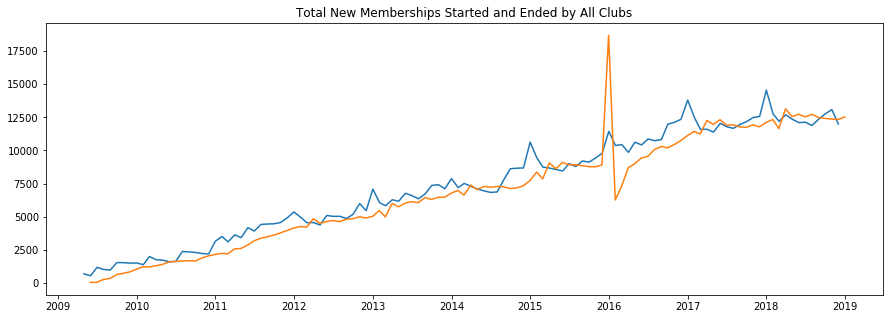

In [35]:
plt.figure(figsize=(15,5))
plt.plot_date(subs['Join Date'].value_counts().sort_index().to_frame().index, 
              subs['Join Date'].value_counts().sort_index().to_frame().values, label='Join', linestyle='-', marker='')
plt.plot_date(subs['End Date'].value_counts().sort_index().to_frame().index, 
              subs['End Date'].value_counts().sort_index().to_frame().values, label='End', linestyle='-', marker='')
plt.title("Total New Memberships Started and Ended by All Clubs")
plt.show()

Most new memberships fall on after-summer period (colder weather) through January (New Year resolutions)
Also, a relatively high share of clubs (36%) opened either in the last 3 months of a year or in January.

**(!) Hypothesis to investigate**: There is a significant increase in membership cancelations at the end of each year (for both Standard and Flexible plans). This could be an indication that the members are planning to start the new year with a membership is a different club. If that is the case, company should consider measures to keep these members (e.g. offer a December discount if the membership is renewed for the next year, free day passes (can be used as Xmas presents to friends), etc.) The way to quantify the impact would be by comparison of the benefits offeres to members with the cost of new aquisitions. 
<br>The customers who remain with the club in November-December are less likely to leave in the following months.

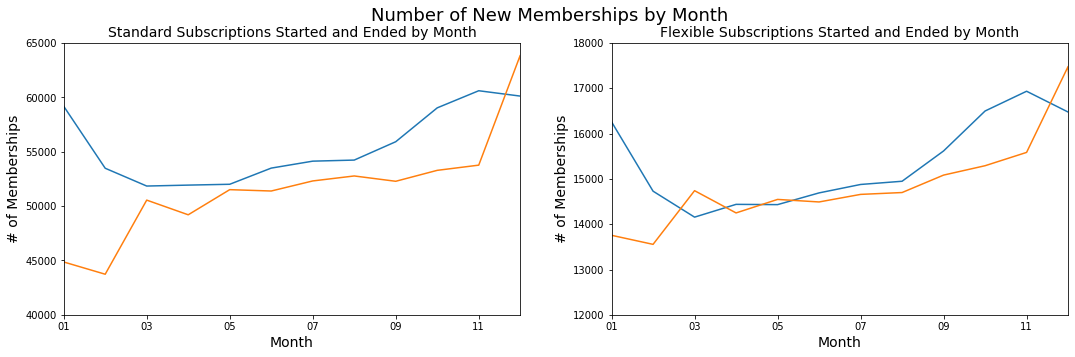

In [135]:
fig, axes = plt.subplots(ncols=2, figsize=(18,5))
fig.suptitle("Number of New Memberships by Month", fontsize = 18)


subs[subs['Subscription Type']=='Standard'].groupby([subs['Join Date'].dt.strftime('%m')])['Join Date'].count().\
plot(ax = axes[0],label='Join')
subs[subs['Subscription Type']=='Standard'].groupby([subs['End Date'].dt.strftime('%m')])['End Date'].count().\
plot(ax = axes[0],label='End')
axes[0].set_xlabel('Month', fontsize = 14)
axes[0].set_ylabel('# of Memberships', fontsize = 14)
axes[0].set_title("Standard Subscriptions Started and Ended by Month", fontsize = 14)
axes[0].set_xlim(0,11)
axes[0].set_ylim(40000,65000)



subs[subs['Subscription Type']=='Flexible'].groupby([subs['Join Date'].dt.strftime('%m')])['Join Date'].count().\
plot(ax = axes[1],label='Join')
subs[subs['Subscription Type']=='Flexible'].groupby([subs['End Date'].dt.strftime('%m')])['End Date'].count().\
plot(ax = axes[1],label='End')
axes[1].set_xlabel('Month', fontsize = 14)
axes[1].set_ylabel('# of Memberships', fontsize = 14)
axes[1].set_title("Flexible Subscriptions Started and Ended by Month", fontsize = 14)
axes[1].set_xlim(0,11)
axes[1].set_ylim(12000,18000)

plt.show()

The cancellations ramp up every year in March (possibly, Janury subscriptions start getting cancelled, enabled by 3-month notice period for standard subscriptions). Another peak in December (members leaving to start new year at other clubs?)

**Review Clubs by Openning vintages**

The first graph shows member additions by clubs opened in a particular year. Although the graph is very busy (which is addressed further with the more granular graphs), a few observations: after the initial ramp up the numbers of new members are similar per club on average, except for the clubs open in 2016 (5 new clubs) which brought a comparable number of members to the 7 clubs open in 2011. The 2017 clubs (3 openings) also show higher numbers that those from 2010 and 2012 (also 3 new clubs in each).

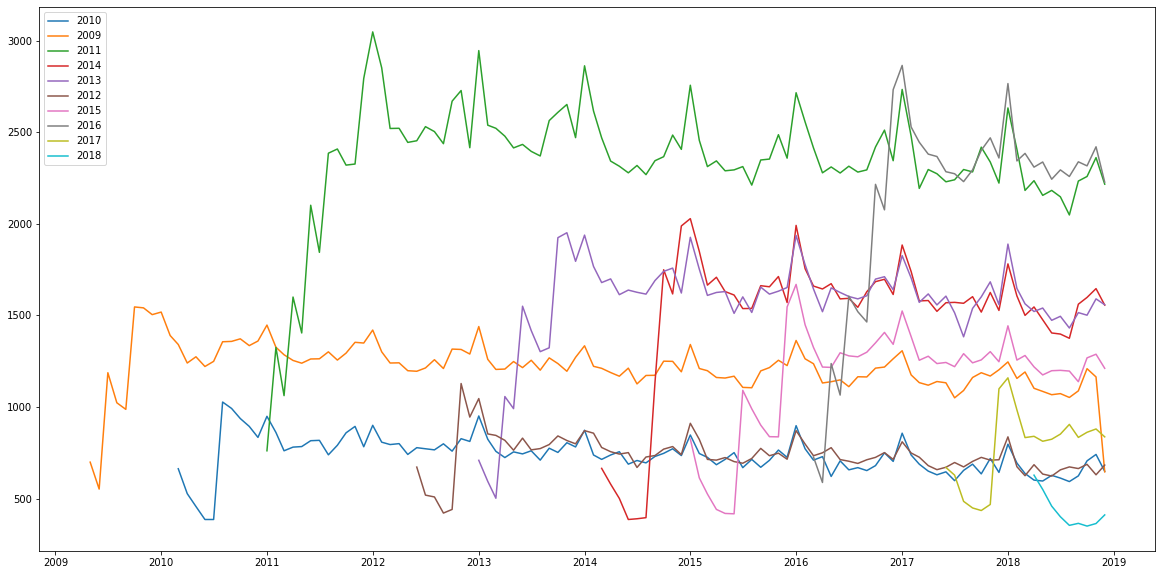

In [139]:
subs_yr = pd.DataFrame()

plt.figure(figsize=(20,10))

for t in subs['club_open_yr'].unique():
    subs_yr = subs[subs['club_open_yr']==t]
    plt.plot_date(subs_yr['Join Date'].value_counts().sort_index().to_frame().index, subs_yr['Join Date'].value_counts().sort_index().to_frame().values, label=t, linestyle='-', marker='')

plt.legend()
plt.show()


From the clubs opened in 2009, the one in Richmond upon Thames showed lowers numbers for new memberships and highest variability.

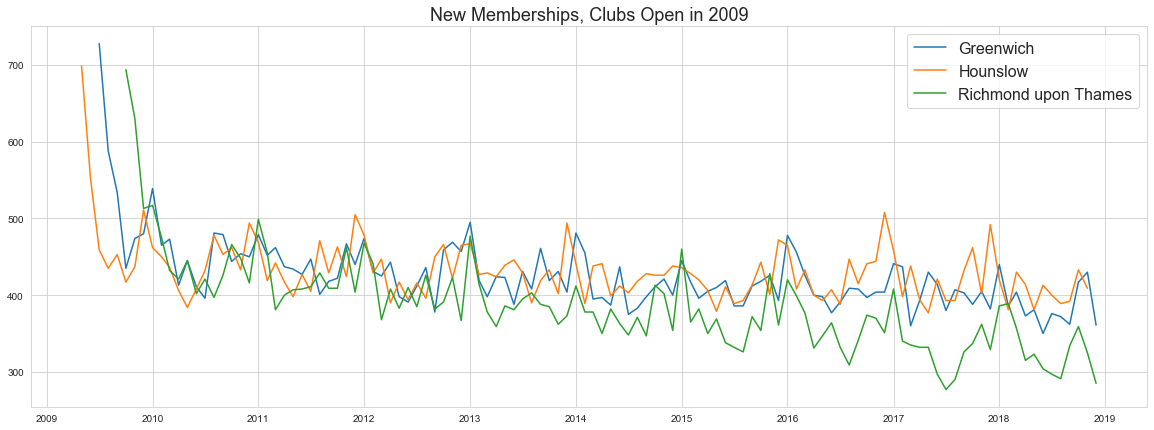

In [193]:
subs_2009=subs[subs['club_open_yr']==2009]
subs_2009_club = pd.DataFrame()

plt.figure(figsize=(20,7))

for t in subs_2009['Club'].unique():
    subs_2009_club = subs_2009[subs_2009['Club']==t]
    plt.plot_date(subs_2009_club['Join Date'].value_counts().sort_index().to_frame().index, 
                  subs_2009_club['Join Date'].value_counts().sort_index().to_frame().values, 
                  label=t, linestyle='-', marker='')

plt.legend(fontsize = 16)
plt.title('New Memberships, Clubs Open in 2009', fontsize = 18)
plt.show()

Enfield club is a lower performer and has a similar profile to the Richmond upon Thames from 2009.

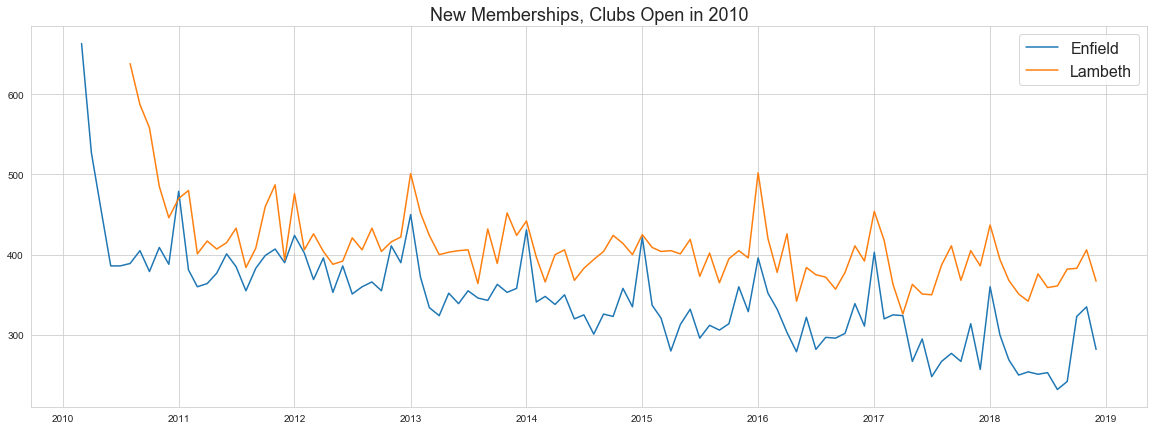

In [195]:
subs_2010=subs[subs['club_open_yr']==2010]
subs_2010_club = pd.DataFrame()

plt.figure(figsize=(20,7))

for t in subs_2010['Club'].unique():
    subs_2010_club = subs_2010[subs_2010['Club']==t]
    plt.plot_date(subs_2010_club['Join Date'].value_counts().sort_index().to_frame().index, 
                  subs_2010_club['Join Date'].value_counts().sort_index().to_frame().values, 
                  label=t, linestyle='-', marker='')

plt.legend(fontsize = 16)
plt.title('New Memberships, Clubs Open in 2010', fontsize = 18)
plt.show()

From the 6 new clubs opened in 2011, 4 were average performers in terms of new subscription, 1 lower performer (Westminster), and 1 relatively high performer (Havering)

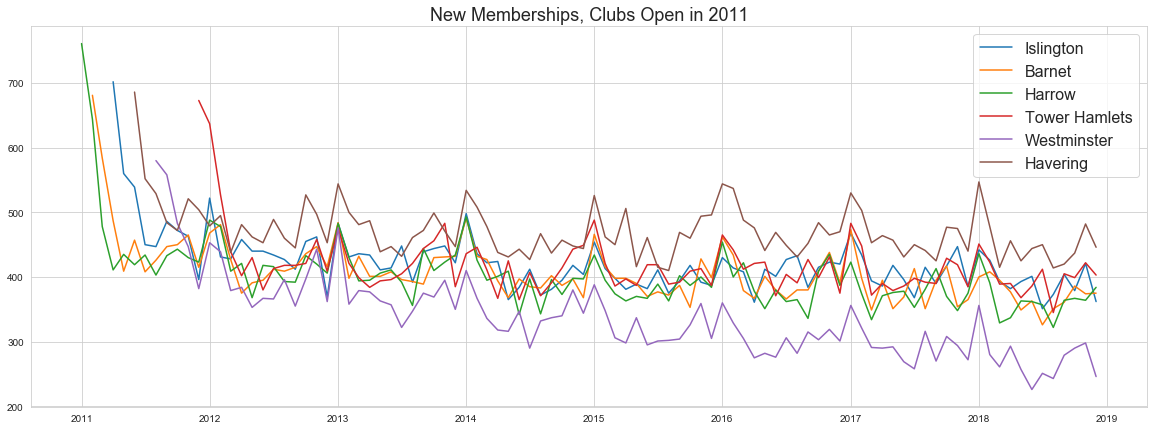

In [216]:
subs_2011=subs[subs['club_open_yr']==2011]
subs_2011_club = pd.DataFrame()

plt.figure(figsize=(20,7))

for t in subs_2011['Club'].unique():
    subs_2011_club = subs_2011[subs_2011['Club']==t]
    plt.plot_date(subs_2011_club['Join Date'].value_counts().sort_index().to_frame().index, 
                  subs_2011_club['Join Date'].value_counts().sort_index().to_frame().values, 
                  label=t, linestyle='-', marker='')

plt.legend(fontsize = 16)
plt.title('New Memberships, Clubs Open in 2011', fontsize = 18)
plt.show()

Both 2012 vintage clubs had gradually slipping enrollment numbers

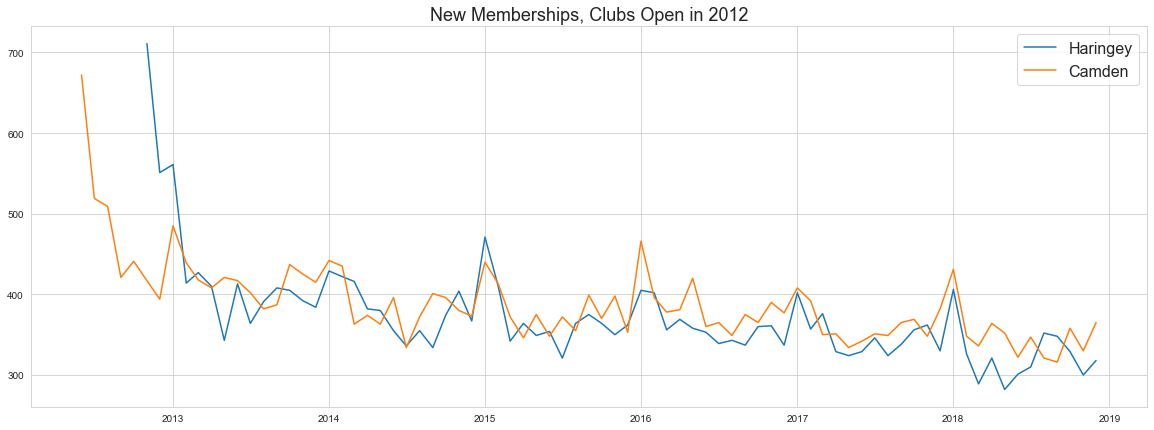

In [217]:
subs_2012=subs[subs['club_open_yr']==2012]
subs_2012_club = pd.DataFrame()

plt.figure(figsize=(20,7))

for t in subs_2012['Club'].unique():
    subs_2012_club = subs_2012[subs_2012['Club']==t]
    plt.plot_date(subs_2012_club['Join Date'].value_counts().sort_index().to_frame().index, 
                  subs_2012_club['Join Date'].value_counts().sort_index().to_frame().values, 
                  label=t, linestyle='-', marker='')

plt.legend(fontsize = 16)
plt.title('New Memberships, Clubs Open in 2012', fontsize = 18)
plt.show()

3 average performers, 1 lower (Sutton) for clubs open in 2013

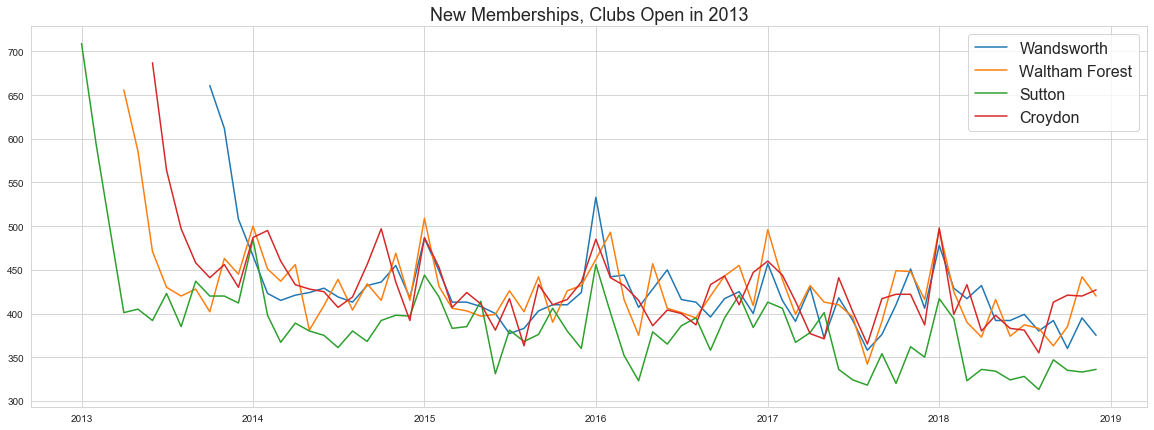

In [218]:
subs_2013=subs[subs['club_open_yr']==2013]
subs_2013_club = pd.DataFrame()

plt.figure(figsize=(20,7))

for t in subs_2013['Club'].unique():
    subs_2013_club = subs_2013[subs_2013['Club']==t]
    plt.plot_date(subs_2013_club['Join Date'].value_counts().sort_index().to_frame().index, 
                  subs_2013_club['Join Date'].value_counts().sort_index().to_frame().values, 
                  label=t, linestyle='-', marker='')

plt.legend(fontsize = 16)
plt.title('New Memberships, Clubs Open in 2013', fontsize = 18)
plt.show()

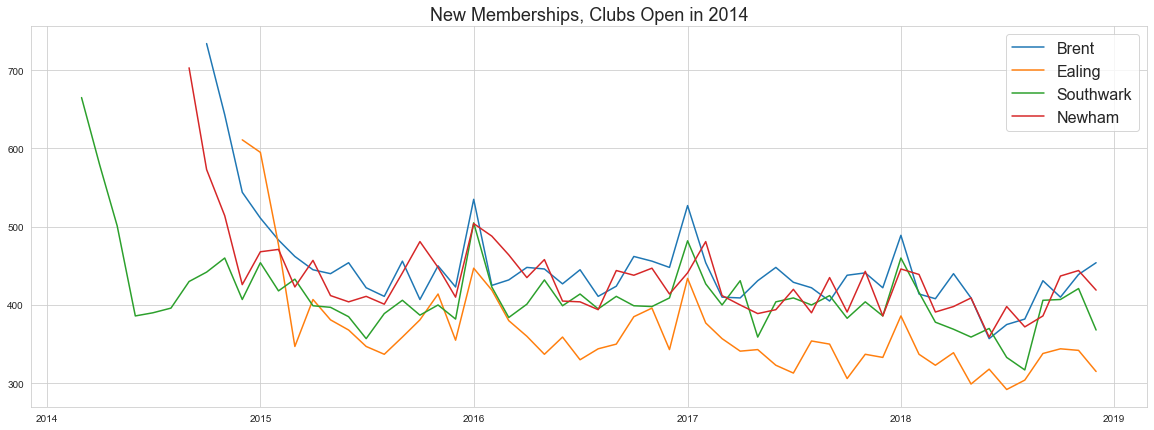

In [219]:
subs_2014=subs[subs['club_open_yr']==2014]
subs_2014_club = pd.DataFrame()

plt.figure(figsize=(20,7))

for t in subs_2014['Club'].unique():
    subs_2014_club = subs_2014[subs_2014['Club']==t]
    plt.plot_date(subs_2014_club['Join Date'].value_counts().sort_index().to_frame().index, 
                  subs_2014_club['Join Date'].value_counts().sort_index().to_frame().values, 
                  label=t, linestyle='-', marker='')

plt.legend(fontsize = 16)
plt.title('New Memberships, Clubs Open in 2014', fontsize = 18)
plt.show()

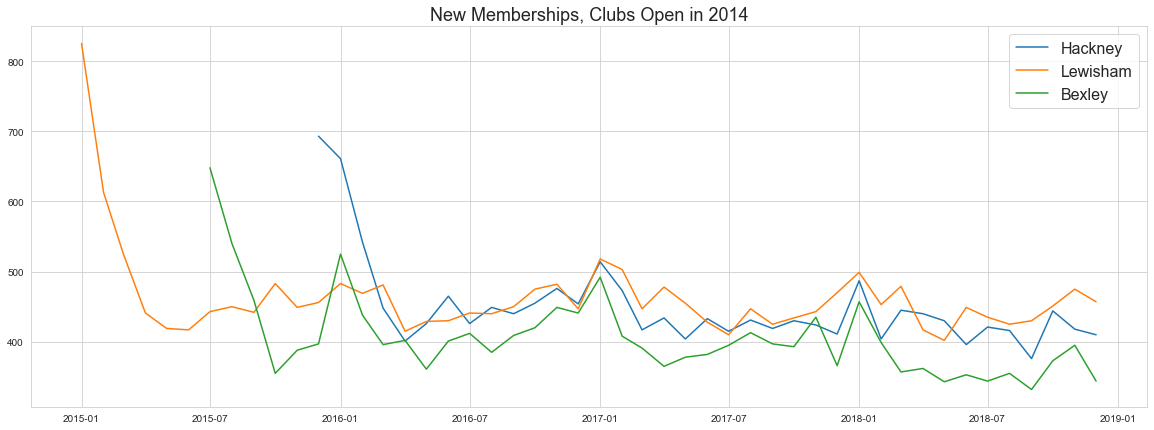

In [220]:
subs_2015=subs[subs['club_open_yr']==2015]
subs_2015_club = pd.DataFrame()

plt.figure(figsize=(20,7))

for t in subs_2015['Club'].unique():
    subs_2015_club = subs_2015[subs_2015['Club']==t]
    plt.plot_date(subs_2015_club['Join Date'].value_counts().sort_index().to_frame().index, 
                  subs_2015_club['Join Date'].value_counts().sort_index().to_frame().values, 
                  label=t, linestyle='-', marker='')

plt.legend(fontsize = 16)
plt.title('New Memberships, Clubs Open in 2015', fontsize = 18)
plt.show()

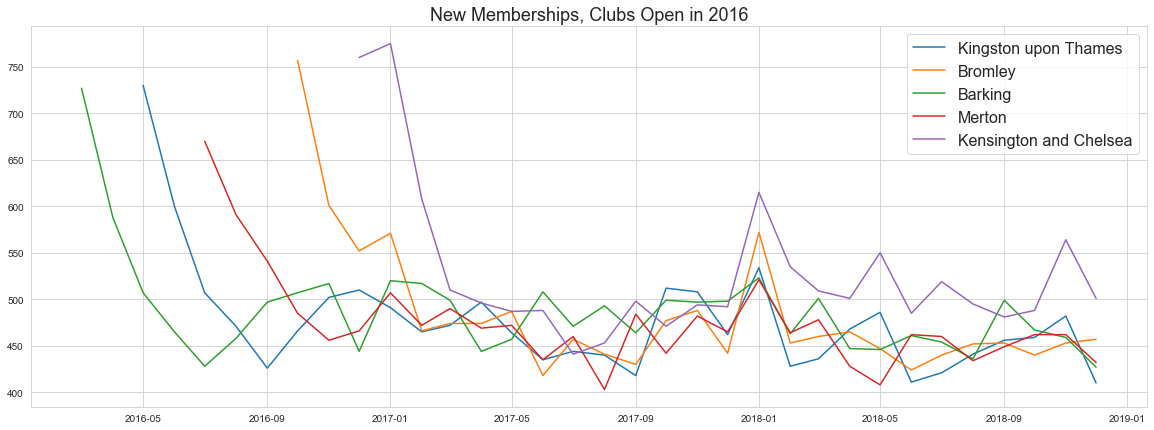

In [221]:
subs_2016=subs[subs['club_open_yr']==2016]
subs_2016_club = pd.DataFrame()

plt.figure(figsize=(20,7))

for t in subs_2016['Club'].unique():
    subs_2016_club = subs_2016[subs_2016['Club']==t]
    plt.plot_date(subs_2016_club['Join Date'].value_counts().sort_index().to_frame().index, 
                  subs_2016_club['Join Date'].value_counts().sort_index().to_frame().values, 
                  label=t, linestyle='-', marker='')

plt.legend(fontsize = 16)
plt.title('New Memberships, Clubs Open in 2016', fontsize = 18)
plt.show()

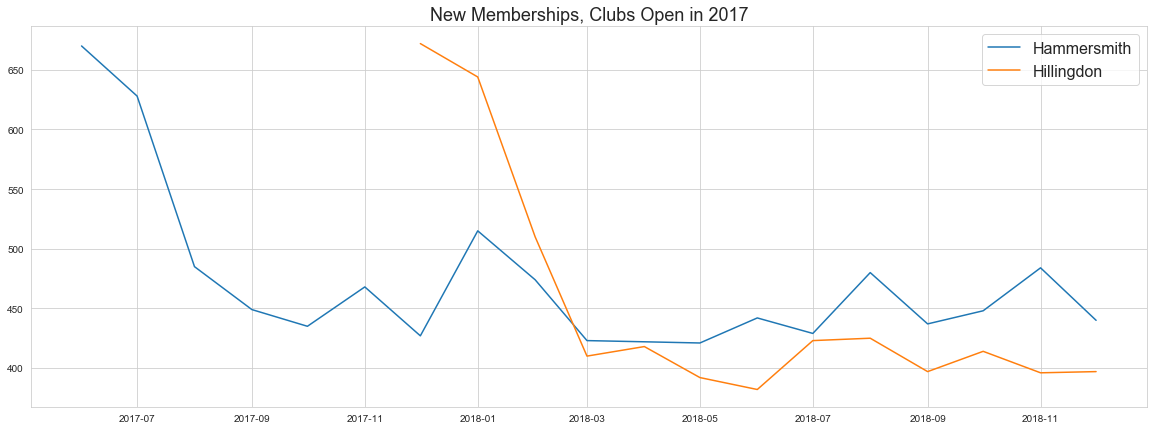

In [222]:
subs_2017=subs[subs['club_open_yr']==2017]
subs_2017_club = pd.DataFrame()

plt.figure(figsize=(20,7))

for t in subs_2017['Club'].unique():
    subs_2017_club = subs_2017[subs_2017['Club']==t]
    plt.plot_date(subs_2017_club['Join Date'].value_counts().sort_index().to_frame().index, 
                  subs_2017_club['Join Date'].value_counts().sort_index().to_frame().values, 
                  label=t, linestyle='-', marker='')

plt.legend(fontsize = 16)
plt.title('New Memberships, Clubs Open in 2017', fontsize = 18)
plt.show()

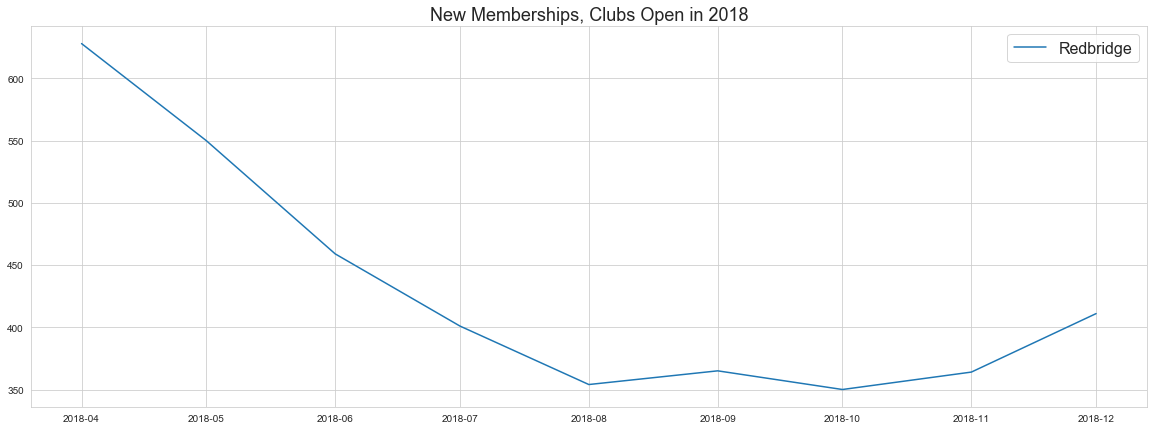

In [223]:
subs_2018=subs[subs['club_open_yr']==2018]
subs_2018_club = pd.DataFrame()

plt.figure(figsize=(20,7))

for t in subs_2018['Club'].unique():
    subs_2018_club = subs_2018[subs_2018['Club']==t]
    plt.plot_date(subs_2018_club['Join Date'].value_counts().sort_index().to_frame().index, 
                  subs_2018_club['Join Date'].value_counts().sort_index().to_frame().values, 
                  label=t, linestyle='-', marker='')

plt.legend(fontsize = 16)
plt.title('New Memberships, Clubs Open in 2018', fontsize = 18)
plt.show()

**Create a dataframe with numbers of active subscribers**

In [3]:
def iterrows_sol(df):
    active_subscribers = pd.DataFrame({
    'Date': pd.date_range(start=df['Join Date'].min(), end=df['End Date'].max()),
    'Number': 0,})

    active_subscribers.set_index('Date', inplace=True)

    for index, row in df.iterrows():
        for this_date in pd.date_range(start=row['Join Date'], end=row['End Date']):
            active_subscribers.loc[this_date, 'Number'] += 1
    return active_subscribers

In [4]:
subs_end_date_filled = subs.copy()
subs_end_date_filled['End Date'].fillna(value=pd.to_datetime('1/1/2019'), inplace=True) 

In [159]:
# (!) takes very long time to run. uncomment to execute
#iterrows_sol(subs_end_date_filled)
subs_end_date_filled_Red = subs_end_date_filled[subs_end_date_filled['Club']=='Redbridge']
active_subs_Red =iterrows_sol(subs_end_date_filled_Red)

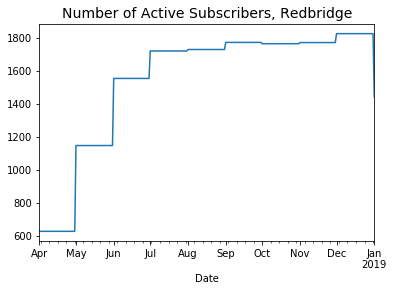

In [160]:
active_subs_Red.plot(legend= False)
plt.title('Number of Active Subscribers, Redbridge', fontsize = 14)
plt.show()

In [248]:
subs_end_date_filled_Hil = subs_end_date_filled[subs_end_date_filled['Club']=='Hillingdon']
active_subs_Hil =iterrows_sol(subs_end_date_filled_Hil)

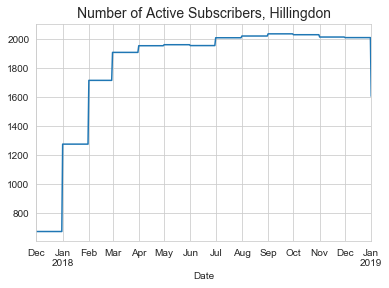

In [247]:
active_subs_Hil.plot(legend= False)
plt.title('Number of Active Subscribers, Hillingdon', fontsize = 14)
plt.show()

In [249]:
subs_end_date_filled_Ham = subs_end_date_filled[subs_end_date_filled['Club']=='Hammersmith']
active_subs_Ham =iterrows_sol(subs_end_date_filled_Ham)

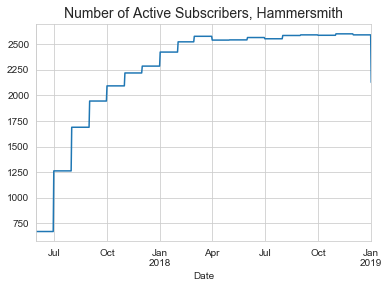

In [250]:
active_subs_Ham.plot(legend= False)
plt.title('Number of Active Subscribers, Hammersmith', fontsize = 14)
plt.show()

In [251]:
subs_end_date_filled_Ken = subs_end_date_filled[subs_end_date_filled['Club']=='Kensington and Chelsea']
active_subs_Ken =iterrows_sol(subs_end_date_filled_Ken)

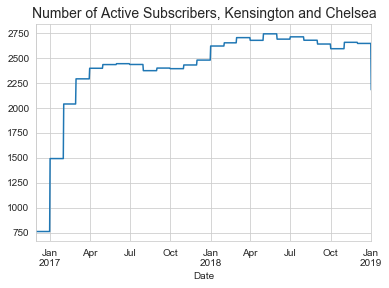

In [252]:
active_subs_Ken.plot(legend= False)
plt.title('Number of Active Subscribers, Kensington and Chelsea', fontsize = 14)
plt.show()

In [253]:
subs_end_date_filled_Bro = subs_end_date_filled[subs_end_date_filled['Club']=='Bromley']
active_subs_Bro =iterrows_sol(subs_end_date_filled_Bro)

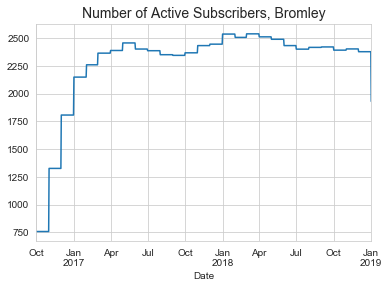

In [256]:
active_subs_Bro.plot(legend= False)
plt.title('Number of Active Subscribers, Bromley', fontsize = 14)
plt.show()

In [257]:
subs_end_date_filled_Mer = subs_end_date_filled[subs_end_date_filled['Club']=='Merton']
active_subs_Mer =iterrows_sol(subs_end_date_filled_Mer)

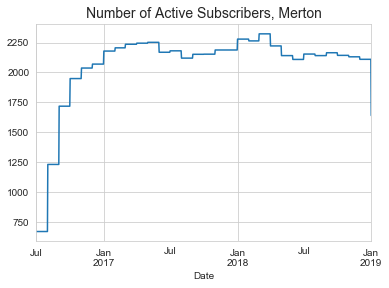

In [258]:
active_subs_Mer.plot(legend= False)
plt.title('Number of Active Subscribers, Merton', fontsize = 14)
plt.show()

In [260]:
subs_end_date_filled_Kin = subs_end_date_filled[subs_end_date_filled['Club']=='Kingston upon Thames']
active_subs_Kin =iterrows_sol(subs_end_date_filled_Kin)

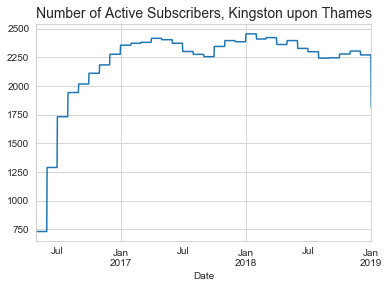

In [261]:
active_subs_Kin.plot(legend= False)
plt.title('Number of Active Subscribers, Kingston upon Thames', fontsize = 14)
plt.show()

In [262]:
subs_end_date_filled_Bar = subs_end_date_filled[subs_end_date_filled['Club']=='Barking']
active_subs_Bar =iterrows_sol(subs_end_date_filled_Bar)

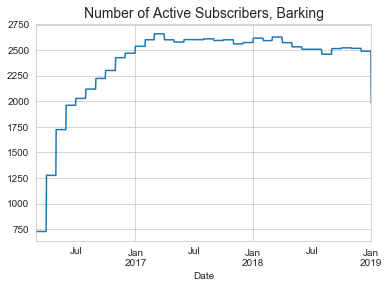

In [263]:
active_subs_Bar.plot(legend= False)
plt.title('Number of Active Subscribers, Barking', fontsize = 14)
plt.show()

In [264]:
subs_end_date_filled_Hac = subs_end_date_filled[subs_end_date_filled['Club']=='Hackney']
active_subs_Hac =iterrows_sol(subs_end_date_filled_Hac)

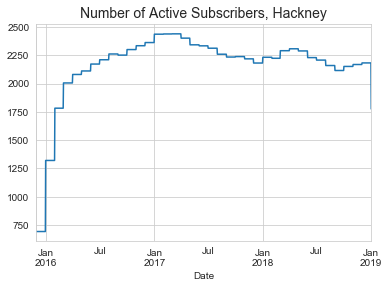

In [265]:
active_subs_Hac.plot(legend= False)
plt.title('Number of Active Subscribers, Hackney', fontsize = 14)
plt.show()

In [266]:
subs_end_date_filled_Bex = subs_end_date_filled[subs_end_date_filled['Club']=='Bexley']
active_subs_Bex =iterrows_sol(subs_end_date_filled_Bex)

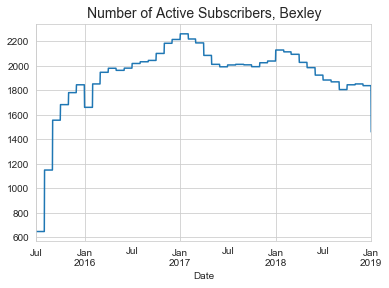

In [267]:
active_subs_Bex.plot(legend= False)
plt.title('Number of Active Subscribers, Bexley', fontsize = 14)
plt.show()

In [269]:
subs_end_date_filled_Lew = subs_end_date_filled[subs_end_date_filled['Club']=='Lewisham']
active_subs_Lew =iterrows_sol(subs_end_date_filled_Lew)

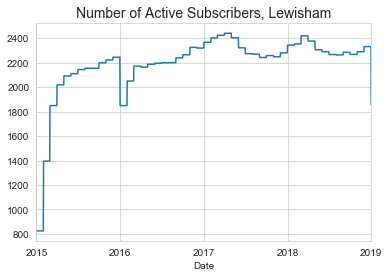

In [270]:
active_subs_Lew.plot(legend= False)
plt.title('Number of Active Subscribers, Lewisham', fontsize = 14)
plt.show()

In [271]:
subs_end_date_filled_Eal = subs_end_date_filled[subs_end_date_filled['Club']=='Ealing']
active_subs_Eal =iterrows_sol(subs_end_date_filled_Eal)

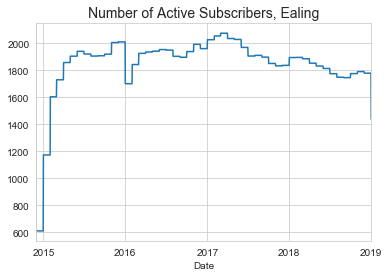

In [272]:
active_subs_Eal.plot(legend= False)
plt.title('Number of Active Subscribers, Ealing', fontsize = 14)
plt.show()

In [273]:
subs_end_date_filled_Bre = subs_end_date_filled[subs_end_date_filled['Club']=='Brent']
active_subs_Bre =iterrows_sol(subs_end_date_filled_Bre)

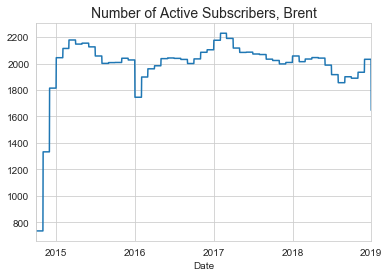

In [274]:
active_subs_Bre.plot(legend= False)
plt.title('Number of Active Subscribers, Brent', fontsize = 14)
plt.show()

In [301]:
subs_end_date_filled_New = subs_end_date_filled[subs_end_date_filled['Club']=='Newham']
active_subs_New =iterrows_sol(subs_end_date_filled_New)

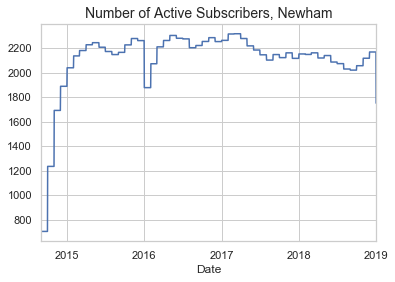

In [392]:
active_subs_New.plot(legend= False)
plt.title('Number of Active Subscribers, Newham', fontsize = 14)
sns.set(font_scale=1)
sns.set_style("whitegrid", {'axes.grid' : True})
plt.show()

In [352]:
subs_end_date_filled_Sou = subs_end_date_filled[subs_end_date_filled['Club']=='Southwark']
active_subs_Sou =iterrows_sol(subs_end_date_filled_Sou)

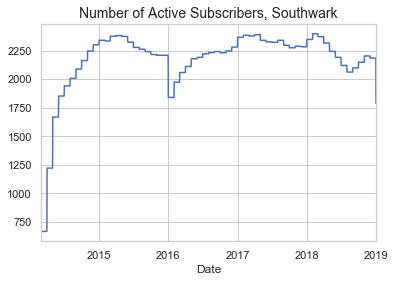

In [393]:
active_subs_Sou.plot(legend= False)
plt.title('Number of Active Subscribers, Southwark', fontsize = 14)
plt.show()

In [305]:
subs_end_date_filled_Wan = subs_end_date_filled[subs_end_date_filled['Club']=='Wandsworth']
active_subs_Wan =iterrows_sol(subs_end_date_filled_Wan)

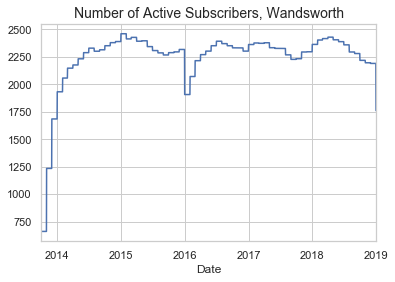

In [394]:
active_subs_Wan.plot(legend= False)
plt.title('Number of Active Subscribers, Wandsworth', fontsize = 14)
plt.show()

In [307]:
subs_end_date_filled_Cro = subs_end_date_filled[subs_end_date_filled['Club']=='Croydon']
active_subs_Cro =iterrows_sol(subs_end_date_filled_Cro)

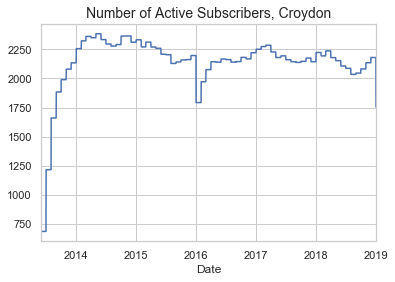

In [395]:
active_subs_Cro.plot(legend= False)
plt.title('Number of Active Subscribers, Croydon', fontsize = 14)
plt.show()

In [309]:
subs_end_date_filled_Wal = subs_end_date_filled[subs_end_date_filled['Club']=='Waltham Forest']
active_subs_Wal =iterrows_sol(subs_end_date_filled_Wal)

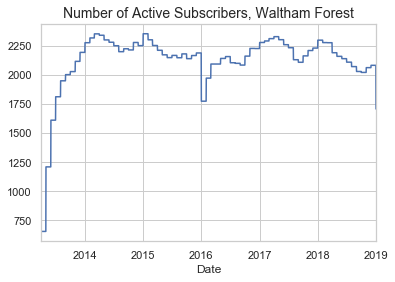

In [396]:
active_subs_Wal.plot(legend= False)
plt.title('Number of Active Subscribers, Waltham Forest', fontsize = 14)
plt.show()

(!) Clubs opened in 2012 and earlier are more likely to have a declining membership base (some quite considerably

In [311]:
subs_end_date_filled_Sut = subs_end_date_filled[subs_end_date_filled['Club']=='Sutton']
active_subs_Sut =iterrows_sol(subs_end_date_filled_Sut)

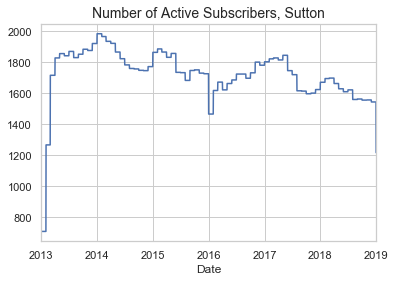

In [397]:
active_subs_Sut.plot(legend= False)
plt.title('Number of Active Subscribers, Sutton', fontsize = 14)
plt.show()

In [313]:
subs_end_date_filled_Har = subs_end_date_filled[subs_end_date_filled['Club']=='Haringey']
active_subs_Har =iterrows_sol(subs_end_date_filled_Har)

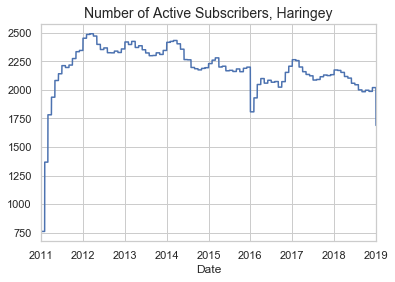

In [398]:
active_subs_Har.plot(legend= False)
plt.title('Number of Active Subscribers, Haringey', fontsize = 14)
plt.show()

In [315]:
subs_end_date_filled_Cam = subs_end_date_filled[subs_end_date_filled['Club']=='Camden']
active_subs_Cam =iterrows_sol(subs_end_date_filled_Cam)

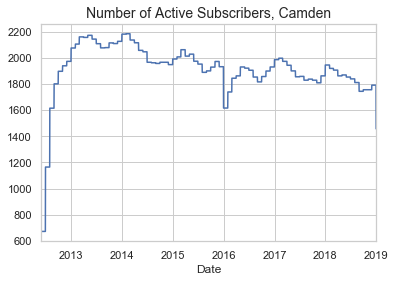

In [399]:
active_subs_Cam.plot(legend= False)
plt.title('Number of Active Subscribers, Camden', fontsize = 14)
plt.show()

In [317]:
subs_end_date_filled_Tow = subs_end_date_filled[subs_end_date_filled['Club']=='Tower Hamlets']
active_subs_Tow =iterrows_sol(subs_end_date_filled_Tow)

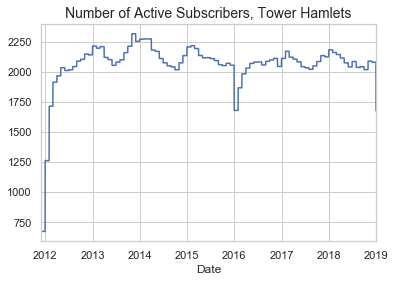

In [400]:
active_subs_Tow.plot(legend= False)
plt.title('Number of Active Subscribers, Tower Hamlets', fontsize = 14)
plt.show()

In [319]:
subs_end_date_filled_Wes = subs_end_date_filled[subs_end_date_filled['Club']=='Westminster']
active_subs_Wes =iterrows_sol(subs_end_date_filled_Wes)

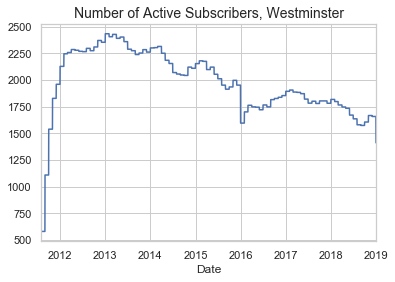

In [401]:
active_subs_Wes.plot(legend= False)
plt.title('Number of Active Subscribers, Westminster', fontsize = 14)
plt.show()

In [321]:
subs_end_date_filled_Hav = subs_end_date_filled[subs_end_date_filled['Club']=='Havering']
active_subs_Hav =iterrows_sol(subs_end_date_filled_Hav)

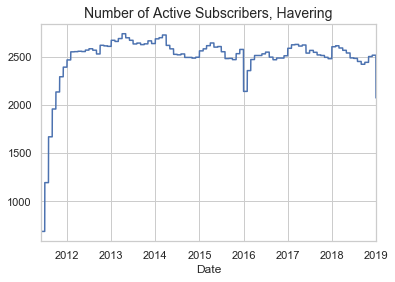

In [402]:
active_subs_Hav.plot(legend= False)
plt.title('Number of Active Subscribers, Havering', fontsize = 14)
plt.show()

In [323]:
subs_end_date_filled_Isl = subs_end_date_filled[subs_end_date_filled['Club']=='Islington']
active_subs_Isl =iterrows_sol(subs_end_date_filled_Isl)

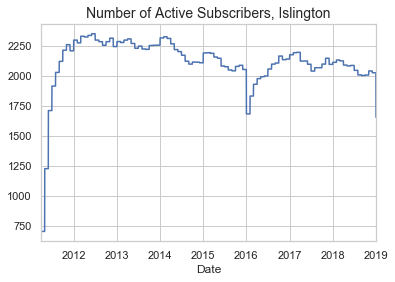

In [403]:
active_subs_Isl.plot(legend= False)
plt.title('Number of Active Subscribers, Islington', fontsize = 14)
plt.show()

In [325]:
subs_end_date_filled_Bar = subs_end_date_filled[subs_end_date_filled['Club']=='Barnet']
active_subs_Bar =iterrows_sol(subs_end_date_filled_Bar)

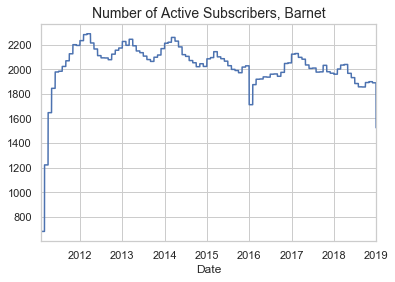

In [404]:
active_subs_Bar.plot(legend= False)
plt.title('Number of Active Subscribers, Barnet', fontsize = 14)
plt.show()

In [327]:
subs_end_date_filled_Har = subs_end_date_filled[subs_end_date_filled['Club']=='Harrow']
active_subs_Har =iterrows_sol(subs_end_date_filled_Har)

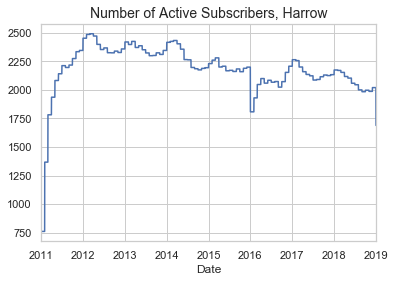

In [405]:
active_subs_Har.plot(legend= False)
plt.title('Number of Active Subscribers, Harrow', fontsize = 14)
plt.show()

In [329]:
subs_end_date_filled_Lam = subs_end_date_filled[subs_end_date_filled['Club']=='Lambeth']
active_subs_Lam =iterrows_sol(subs_end_date_filled_Lam)

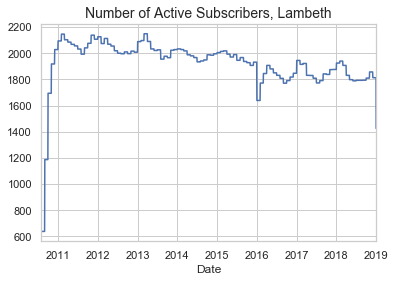

In [406]:
active_subs_Lam.plot(legend= False)
plt.title('Number of Active Subscribers, Lambeth', fontsize = 14)
plt.show()

In [331]:
subs_end_date_filled_Enf = subs_end_date_filled[subs_end_date_filled['Club']=='Enfield']
active_subs_Enf =iterrows_sol(subs_end_date_filled_Enf)

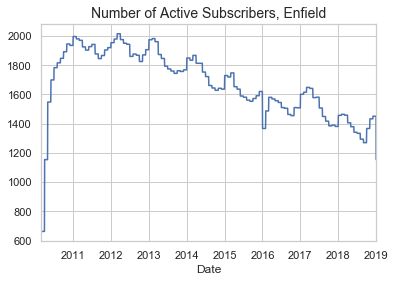

In [407]:
active_subs_Enf.plot(legend= False)
plt.title('Number of Active Subscribers, Enfield', fontsize = 14)
plt.show()

In [333]:
subs_end_date_filled_Ric = subs_end_date_filled[subs_end_date_filled['Club']=='Richmond upon Thames']
active_subs_Ric =iterrows_sol(subs_end_date_filled_Ric)

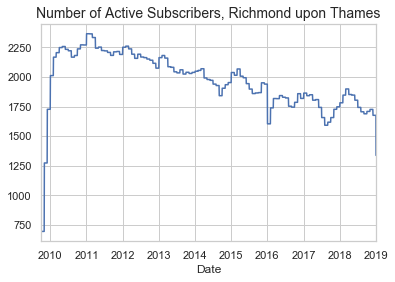

In [408]:
active_subs_Ric.plot(legend= False)
plt.title('Number of Active Subscribers, Richmond upon Thames', fontsize = 14)
plt.show()

In [335]:
subs_end_date_filled_Gre = subs_end_date_filled[subs_end_date_filled['Club']=='Greenwich']
active_subs_Gre =iterrows_sol(subs_end_date_filled_Gre)

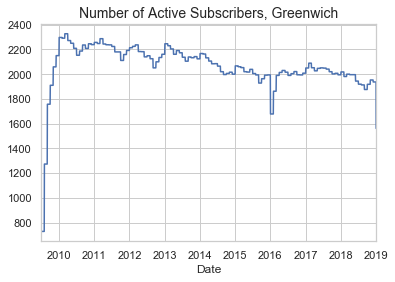

In [409]:
active_subs_Gre.plot(legend= False)
plt.title('Number of Active Subscribers, Greenwich', fontsize = 14)
plt.show()

In [339]:
subs_end_date_filled_Hou = subs_end_date_filled[subs_end_date_filled['Club']=='Hounslow']
active_subs_Hou =iterrows_sol(subs_end_date_filled_Hou)

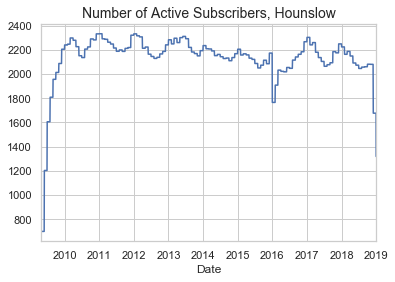

In [410]:
active_subs_Hou.plot(legend= False)
plt.title('Number of Active Subscribers, Hounslow', fontsize = 14)
plt.show()